In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import RobustScaler

from numpy.random import seed
from sklearn.svm import OneClassSVM
import time
import glob
import pathlib

from scipy.signal import find_peaks
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
from joblib import Parallel, delayed
import random

import matplotlib.pyplot as plt

import warnings

The dataset used in this notebook can be found at: https://www.data-in-brief.com/action/showPdf?pii=S2352-3409%2822%2900517-0

# Data preparation

In [3]:
# Constants
DIM_SAMPLES = 500
SAMPLING_FREQ = 12000  # Hz
DATA_DIR = 'data/CWRU/1_csv'

In [4]:
# Define the nominal time-series
nominal_time_series = []
df = pd.read_csv(f'{DATA_DIR}/Nominal/MotorLoad0.csv')

dfs = df.groupby(np.arange(len(df))//DIM_SAMPLES)  # Split into segments
[nominal_time_series.append(t[1]) for t in list(dfs)[:-1]]  # Ignore the last, as it may be too short

print(f"We have {len(nominal_time_series)} nominal time-series, each one of length {DIM_SAMPLES}.")

We have 487 nominal time-series, each one of length 500.


In [10]:
# Define the anomalous samples
## We create a dictionary: the key is the class of anomaly, the value the related samples
anomalous_time_series = {}

for f in sorted(glob.glob(f'{DATA_DIR}/12k_Drive/**/*.csv', recursive=True)):
    if 'ball' in f:
        position = f[32:36]
        strength = f[-5]
        severity = f[26:31]
    else:
        position = f[32:37]
        strength = f[-5]
        severity = f[26:31]

    classs = f"{severity}mm-{position}-{strength}W"

    anomalous_time_series[classs] = []  # Initialize list of time-series
    
    df = pd.read_csv(f)
    dfs = df.groupby(np.arange(len(df))//DIM_SAMPLES)
    [anomalous_time_series[classs].append(t[1]) for t in list(dfs)[:-1]]  # Ignore the last, as it may be too short
    
print(f"We have {len(anomalous_time_series.keys())} classes of anomaly (of increasing severity):")
for k, v in anomalous_time_series.items():
    print(f"{k}: {len(anomalous_time_series[k])} time-series, each one of length {DIM_SAMPLES}")

We have 35 classes of anomaly (of increasing severity):
0_007mm-ball-0W: 242 time-series, each one of length 500
0_007mm-ball-1W: 241 time-series, each one of length 500
0_007mm-ball-2W: 243 time-series, each one of length 500
0_007mm-ball-3W: 242 time-series, each one of length 500
0_007mm-inner-0W: 243 time-series, each one of length 500
0_007mm-inner-1W: 242 time-series, each one of length 500
0_007mm-inner-2W: 242 time-series, each one of length 500
0_007mm-inner-3W: 243 time-series, each one of length 500
0_007mm-outer-0W: 241 time-series, each one of length 500
0_007mm-outer-1W: 242 time-series, each one of length 500
0_007mm-outer-2W: 243 time-series, each one of length 500
0_007mm-outer-3W: 243 time-series, each one of length 500
0_014mm-ball-0W: 244 time-series, each one of length 500
0_014mm-ball-1W: 243 time-series, each one of length 500
0_014mm-ball-2W: 244 time-series, each one of length 500
0_014mm-ball-3W: 242 time-series, each one of length 500
0_014mm-inner-0W: 242 ti

# Data visualization: some FFTs

In [11]:
nominal_sample   = nominal_time_series[0]
anomalous_sample = anomalous_time_series[list(anomalous_time_series.keys())[-1]][0]
display(nominal_sample)

,0.0531969230769231,0.145667272727273
0,0.088662,0.097796
1,0.099718,0.054856
2,0.058621,0.036982
3,-0.004590,0.054445
4,-0.056952,0.021162
...,...,...
495,-0.037134,0.138887
496,-0.041723,0.111151
497,-0.003546,0.053418
498,0.042140,0.004520


In [12]:
display(anomalous_sample)

,0.0955118562874252,-0.110078441558442
0,-0.004629,-0.112843
1,-0.049786,0.052600
2,0.102659,-0.020081
3,-0.005360,-0.054226
4,-0.076020,0.112436
...,...,...
495,-0.146273,-0.102355
496,0.038497,0.044470
497,0.003736,-0.008130
498,-0.178435,0.062844


In [13]:
fig = make_subplots(rows=2, cols=2, shared_yaxes=True)

for i, c in enumerate(nominal_sample.columns):
    # Remove the mean
    # signal = nominal_sample.loc[:, c] - np.mean(nominal_sample.loc[:, c])
    signal = nominal_sample.loc[:, c]
    
    # Compute the FFT without square (we cannot do it later with HE)
    fft = abs(np.fft.rfft(signal)) ** 2
    x = np.fft.rfftfreq(len(signal)) * SAMPLING_FREQ

    fig.append_trace(go.Scatter(x=x, y=fft, name=f'FFT {c}'), row=i+1, col=1)
    
for i, c in enumerate(anomalous_sample.columns):
    # Remove the mean
    # signal = anomalous_sample.loc[:, c] - np.mean(anomalous_sample.loc[:, c])
    signal = anomalous_sample.loc[:, c]
    
    # Compute the FFT without square (we cannot do it later with HE)
    fft = abs(np.fft.rfft(signal)) ** 2
    x = np.fft.rfftfreq(len(signal)) * SAMPLING_FREQ

    fig.append_trace(go.Scatter(x=x, y=fft, name=f'FFT {c}'), row=i+1, col=2)

fig.update_layout(height=800, title_text=f"FFT of a nominal sample vs anomalous sample")
fig.show()

# Formula for W

Idea: concatenate a fair number of frequency spectrum of the nominal signal.
Then, apply a clustering algorithm and use the Elbow method to select a fair number of windows.

In [22]:
signals_to_consider = 100
concatenated_ffts = np.array([])

In [23]:
for nominal_sample in nominal_time_series[:signals_to_consider]:
    for i, c in enumerate(nominal_sample.columns):
        # Remove the mean
        # signal = nominal_sample.loc[:, c] - np.mean(nominal_sample.loc[:, c])

        # Compute the FFT without square (we cannot do it later with HE)
        fft = abs(np.fft.rfft(signal)) ** 2
        concatenated_ffts = np.append(concatenated_ffts, fft)

In [24]:
concatenated_ffts.shape

(50200,)

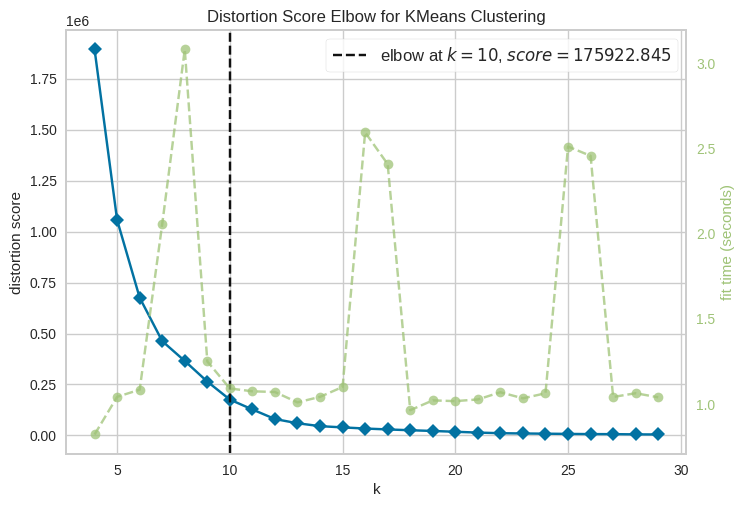

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
model = KMeans()

visualizer = KElbowVisualizer(model, k=(4,30))

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    visualizer.fit(concatenated_ffts.reshape(-1, 1))  # Fit the data to the visualizer

visualizer.show()  # Finalize and render the figure

# Training and test of a OneClassSVM

In [26]:
def preprocess_a_sample(df, windows):
    final_sample = []
    
    for column in df.columns:
        signal = df.loc[:, column]
                
        signal_fft = np.abs(np.fft.rfft(signal)) ** 2
        len_windows = int(len(signal_fft) / windows) - 1
        
        for i in range(windows):
            if i == windows-1:
                final_sample.append(np.mean(signal_fft[i*len_windows:]))
            else:
                final_sample.append(np.mean(signal_fft[i*len_windows:(i+1)*len_windows]))
                
    return np.array(final_sample)

In [27]:
for windows in [10]:
    print(f"###############################")
    print(f"Windows: {windows}\n")
    stats = pd.DataFrame(columns=['Class', 'Total', 'Pred. nominal', 'Pred. anomaly', 'Max dist', 'Min dist'])
        
    preprocessed_samples_nominal = np.array(Parallel()(delayed(preprocess_a_sample)(sample, windows) for sample in nominal_time_series))

    n = int(len(preprocessed_samples_nominal) * 0.8)
    preprocessed_samples_train = preprocessed_samples_nominal[:n]
    preprocessed_samples_test = preprocessed_samples_nominal[n:]
    
    # Define the SVM
    svm = OneClassSVM(nu=0.05, kernel='poly', gamma='scale', degree=2)
    # svm = OneClassSVM(nu=0.01)

    # Train the SVM
    svm.fit(preprocessed_samples_train)
    
    # Stats:
    x_predicted = svm.predict(preprocessed_samples_train)
    max_dist = max(svm.decision_function(preprocessed_samples_train))
    print(f"Samples di training: {len(x_predicted)}")
    print(f"Trovati nominali: {len([x for x in x_predicted if x == 1])}")
    print(f"Trovati anomali: {len([x for x in x_predicted if x == -1])}")
    print(f"Max dist training: {max_dist}\n")
    
    x_predicted = svm.predict(preprocessed_samples_test)
    print(f"Samples di test (nominali): {len(x_predicted)}")
    print(f"Trovati nominali: {len([x for x in x_predicted if x == 1])}")
    print(f"Trovati anomali: {len([x for x in x_predicted if x == -1])}\n")
    
    
    for classs, anomalous_samples in anomalous_time_series.items():
        anomaly_samples = np.array(Parallel()(delayed(preprocess_a_sample)(sample, windows) for sample in anomalous_samples))

        x_predicted = svm.predict(anomaly_samples)
        nominals = len([x for x in x_predicted if x == 1])
        anomalous = len([x for x in x_predicted if x == -1])
        max_dist = max(svm.decision_function(anomaly_samples))
        min_dist = min(svm.decision_function(anomaly_samples))

        stats = pd.concat([stats, pd.DataFrame({'Class': classs, 'Total': len(x_predicted), 'Pred. nominal': nominals,
                              'Pred. anomaly': anomalous, 'Max dist': round(max_dist, 2), 'Min dist': round(min_dist, 2)}, 
                                               index=[0])], ignore_index=True)

    stats = stats.set_index('Class').sort_index()
    print(stats)

###############################
Windows: 10

Samples di training: 389
Trovati nominali: 370
Trovati anomali: 19
Max dist training: 19.28006348679594

Samples di test (nominali): 98
Trovati nominali: 96
Trovati anomali: 2

                 Total Pred. nominal Pred. anomaly  Max dist  Min dist
Class                                                                 
0_007mm-ball-0W    242             1           241      2.24    -10.70
0_007mm-ball-1W    241             5           236    289.33     -9.66
0_007mm-ball-2W    243            51           192      6.13     -9.88
0_007mm-ball-3W    242            63           179      6.35     -8.60
0_007mm-inner-0W   243           188            55     42.69     -6.10
0_007mm-inner-1W   242           108           134     49.49     -8.07
0_007mm-inner-2W   242           119           123     40.62     -7.09
0_007mm-inner-3W   243           197            46     98.36     -5.51
0_007mm-outer-0W   241             0           241     -7.21    -11.